In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
from skimage import io
import keras
import os
import glob
import random

from sklearn.model_selection import train_test_split

from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D, Dense, Flatten, Dropout, MaxPool2D
from tensorflow.keras.applications import VGG16

In [2]:
os.chdir('../')
path = 'B:\data\wildlife'
animal_class = ['buffalo', 'elephant', 'rhino', 'zebra']

# return a list of all file paths
animal_path = os.path.join(path, animal_class[3], '*')
animal_path = glob.glob(animal_path)

image = io.imread(animal_path[324])

Data preprocessing

Text(0.5, 0.98, 'different colors of images')

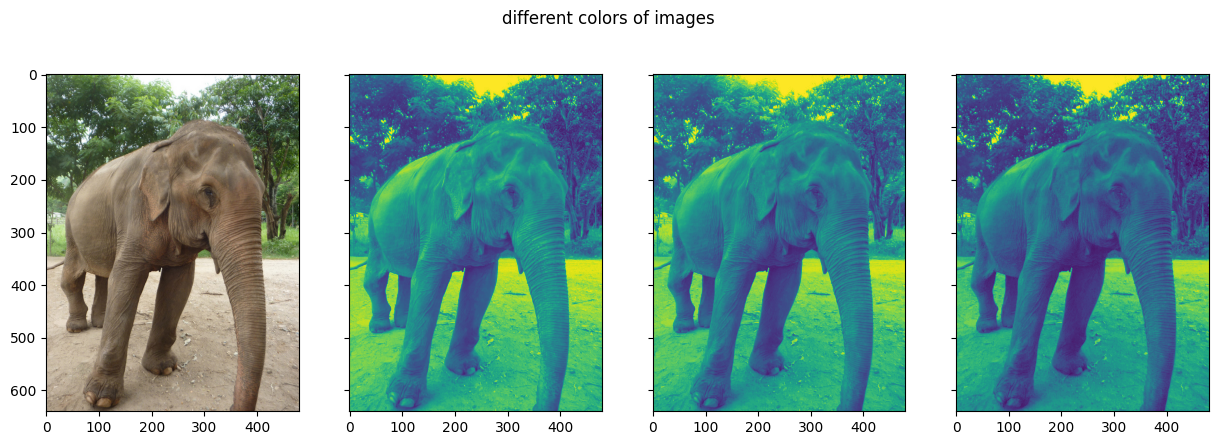

In [5]:
# processing channels and sizes
f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, sharey=True)
f.set_figwidth(15)
ax1.imshow(image)
# RGB channels
ax2.imshow(image[:,:,0])#red
ax3.imshow(image[:,:,1])#green
ax4.imshow(image[:,:,2])#blue
f.suptitle('different colors of images')

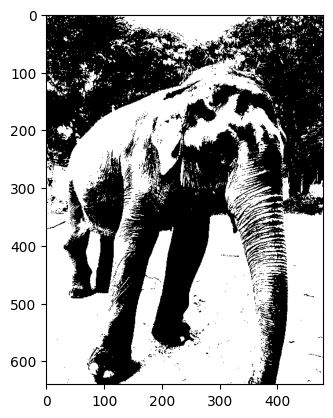

In [6]:
# thresholding
bin_img = image[:,:,0]>125
plt.imshow(bin_img, cmap='gray')

In [7]:
len(bin_img)
bin_img.size

307200

In [8]:
# erosion, dialation, opening and closing
from skimage.morphology import binary_dilation, binary_erosion, binary_opening, binary_closing
from skimage.morphology import disk

mask = disk(4)

open_img = binary_opening(bin_img, mask)
close_img = binary_closing(bin_img, mask)

eroded_img = binary_erosion(bin_img, mask)
dilated_img = binary_dilation(bin_img, mask)


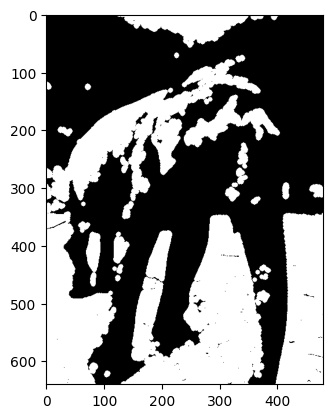

In [9]:
plt.imshow(open_img, cmap='gray')

In [10]:
values= np.concatenate((open_img, close_img, eroded_img, dilated_img), axis=0)
values.shape

(2560, 480)

In [11]:
'''
fig, axes = plt.subplots(1,4, figsize=(25,25))
i=0
for f, ax in enumerate(axes.flat):   
    ax.imshow(values[i].reshape(225,225), cmap='gray')
    i=i+1
'''

"\nfig, axes = plt.subplots(1,4, figsize=(25,25))\ni=0\nfor f, ax in enumerate(axes.flat):   \n    ax.imshow(values[i].reshape(225,225), cmap='gray')\n    i=i+1\n"

In [12]:
# normalization
# mostly for rbg image
norm1 = image/255
# mostly for medical images or non-natural images
norm2 = image - np.min(image)/np.max(image) - np.min(image)
# also for medical or non-natural images
norm3 = image - np.nanpercentile(image,5)/np.percentile(image,95) - np.percentile(image,5)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


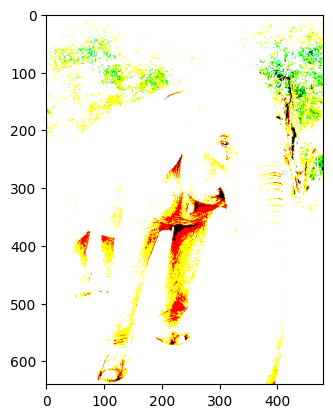

In [13]:
plt.imshow(norm3, cmap='gray')

**********entire data preprocessing**********

In [14]:
'''
from PIL import Image

buffalo_path='/kaggle/input/african-wildlife/buffalo'

for filename in os.listdir(buffalo_path):
    if filename.endswith('jpg') or filename.endswith('png'):
        img = Image.open(os.path.join(buffalo_path, filename))
        img.show()
'''


"\nfrom PIL import Image\n\nbuffalo_path='/kaggle/input/african-wildlife/buffalo'\n\nfor filename in os.listdir(buffalo_path):\n    if filename.endswith('jpg') or filename.endswith('png'):\n        img = Image.open(os.path.join(buffalo_path, filename))\n        img.show()\n"

In [15]:
X_train = np.zeros((1501, 50176, 3), dtype=float)
Y_train = np.zeros(1501, dtype=int)
classes = 0

i=0
for dir in os.listdir(path):
    
    for imgs in os.listdir(path+'/'+dir):
        if imgs.endswith('jpg'):
            org_img = tf.keras.preprocessing.image.load_img(path+'/'+dir+'/'+imgs).resize((224,224))

            org_img_to_array = tf.keras.preprocessing.image.img_to_array(org_img)
            reshaped_img = org_img_to_array.reshape(-1,3)/255.0
            X_train[i,:,:] = reshaped_img
            Y_train[i] = classes
            i=i+1
    classes = classes+1
print('writing to the file')

with open('xtrain.npy','wb') as f:
    np.save(f,X_train)
with open('ytrain.npy', 'wb') as f:
    np.save(f, Y_train)

writing to the file


In [3]:
with open('xtrain.npy','rb') as f:
    x = np.load('xtrain.npy')
with open('ytrain.npy', 'rb') as f:
    y =np.load('ytrain.npy')

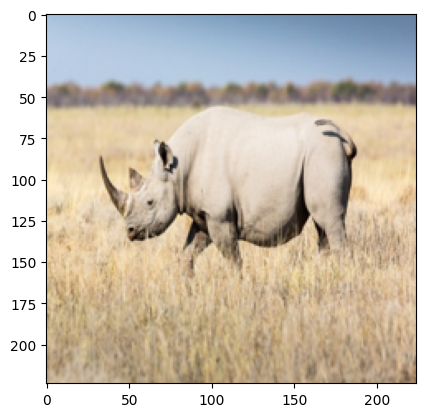

In [17]:
first = tf.keras.preprocessing.image.array_to_img(x[1111].reshape(224,224,3))
plt.imshow(first)

In [4]:
X_train, X_, y_train, y_ = train_test_split(x, y, random_state=False, test_size=0.2, shuffle=True)
X_test, X_val, y_test, y_val = train_test_split(X_, y_, random_state=False, test_size=0.5, shuffle=True)

In [16]:
X_test.shape

(150, 50176, 3)

In [7]:
#VGG16 optimized model for classification
vgg = VGG16(weights="imagenet", include_top=False, input_tensor=tf.keras.Input(shape=(224, 224, 3)))
vgg.trainable = False
flatten = vgg.output
flatten = Flatten()(flatten)
labelHead = Dense(128, activation="relu")(flatten)
labelHead = Dense(64, activation="relu")(labelHead)
labelHead = Dense(32, activation="relu")(labelHead)
labelHead = Dense(4, activation="softmax")(labelHead)
model = tf.keras.Model(inputs=vgg.input, outputs=labelHead)

model.compile(
              loss='sparse_categorical_crossentropy', 
              metrics=['acc'],
              optimizer='adam'
             )

In [6]:
# Creating a Sequential model
model= Sequential()
model.add(Conv2D(kernel_size=(3,3), filters=32, activation='relu', input_shape=(224,224,3)))
model.add(Conv2D(filters=30,kernel_size = (3,3),activation='relu'))
model.add(MaxPool2D(2,2))
model.add(Conv2D(filters=30,kernel_size = (3,3),activation='relu'))
model.add(MaxPool2D(2,2))
model.add(Conv2D(filters=30,kernel_size = (3,3),activation='relu'))

model.add(Flatten())

model.add(Dense(20,activation='relu'))
model.add(Dense(15,activation='relu'))
model.add(Dense(4,activation = 'softmax'))
    
model.compile(
              loss='sparse_categorical_crossentropy', 
              metrics=['acc'],
              optimizer='adam'
             )

In [7]:
history = model.fit(X_train.reshape(-1,224,224,3),y_train,epochs=10,batch_size=16,validation_data=(X_val.reshape(-1,224,224,3),y_val))

Epoch 1/10
75/75 [==============================] - 63s 226ms/step - loss: 1.3891 - acc: 0.2517 - val_loss: 1.2943 - val_acc: 0.3775
Epoch 2/10
75/75 [==============================] - 15s 194ms/step - loss: 1.1699 - acc: 0.4117 - val_loss: 1.0852 - val_acc: 0.4503
Epoch 3/10
75/75 [==============================] - 16s 208ms/step - loss: 1.0451 - acc: 0.4217 - val_loss: 0.9627 - val_acc: 0.4768
Epoch 4/10
75/75 [==============================] - 15s 197ms/step - loss: 0.9621 - acc: 0.5350 - val_loss: 1.0189 - val_acc: 0.4901
Epoch 5/10
75/75 [==============================] - 15s 199ms/step - loss: 0.8623 - acc: 0.5775 - val_loss: 0.9300 - val_acc: 0.5232
Epoch 6/10
75/75 [==============================] - 15s 196ms/step - loss: 0.7930 - acc: 0.6442 - val_loss: 0.9107 - val_acc: 0.6291
Epoch 7/10
75/75 [==============================] - 15s 195ms/step - loss: 0.7331 - acc: 0.6775 - val_loss: 1.0668 - val_acc: 0.5563
Epoch 8/10
75/75 [==============================] - 15s 196ms/step - 

In [9]:
model.save('models/wildlife.h5')

In [30]:
from tensorflow.keras.models import load_model
model = load_model('models/wildlife_vgg16.h5')

In [32]:
class_names = ['buffalo', 'elephant', 'rhino', 'zebra']

In [24]:
a = X_test[0].reshape(224,224,3)
a.shape

(224, 224, 3)

1/1 [==============================] - 0s 108ms/step


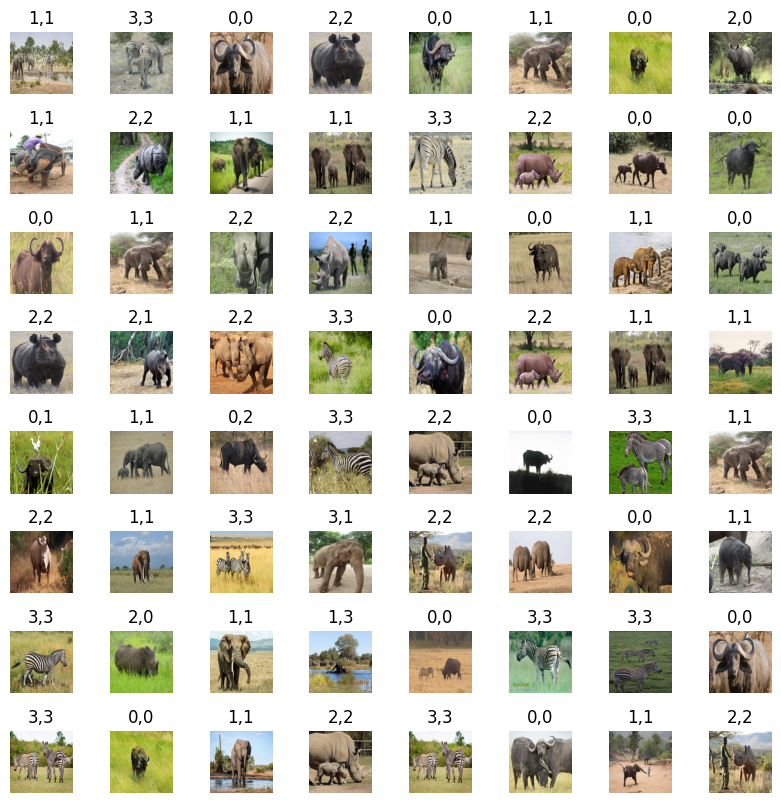

In [22]:
fig,axes = plt.subplots(8,8,figsize=(8,8))
fig.tight_layout(pad=0.1)

for i,ax in enumerate(axes.flat):
    randomindex = np.random.randint(150)
    prediction = model.predict(X_test[randomindex].reshape(-1,224,224,3))
    X_random = X_test[randomindex].reshape(224,224,3)
    ax.imshow(X_random,cmap="gray")
    ax.set_title(f"{y_test[randomindex]},{np.argmax(prediction)}")
    ax.set_axis_off()
   
    
 

In [33]:
y_pred = np.zeros((150,))

for i in range(150):
    prediction = model.predict(X_test[i].reshape(-1,224,224,3))
    value = np.argmax(prediction)
    y_pred[i] = value;
    

1/1 [==============================] - 0s 86ms/step


In [24]:
y_pred[27]

2.0

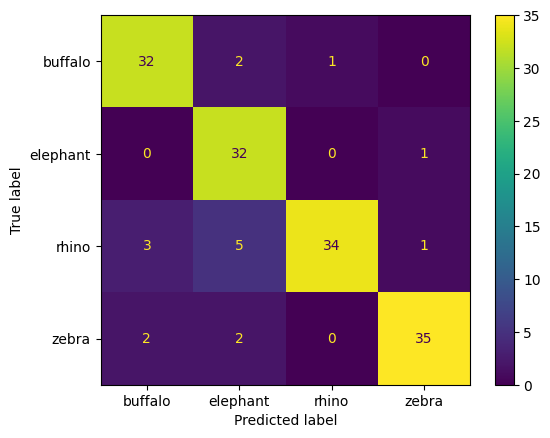

In [34]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_pred)
display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
display.plot()
